# 1. Instalação de dependências

In [ ]:
!pip install -q scikit-learn pandas joblib

# 2. Imports e configurações iniciais

In [ ]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.utils import resample
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold, cross_val_score


import joblib

# 3. Função de limpeza de texto

In [ ]:
def clean_text(text):
  if not isinstance(text, str):
      return ""
  text = text.lower()
  text = re.sub(r"http\S+|www\S+|@\w+|#", " ", text)
  text = re.sub(r"[^a-záàâãéèêíïóôõöúçñ\s]", " ", text)
  text = re.sub(r"\s+", " ", text).strip()
  return text

# 4. Tratamento de Negações

In [ ]:
def handle_negations(text):
  if not isinstance(text, str):
    return ""
  patterns = [
    r"\bno\s+(\w+)",
    r"\bno\s+(\w+)",
    r"\bnunca\s+(\w+)",
    r"\bJamás\s+(\w+)"
  ]
  for p in patterns:
      text = re.sub(p, r"no_\1", text)
  return text

# 5. Tratamento de Intensificadores

In [ ]:
def handle_intensifiers(text):
  if not isinstance(text, str):
    return ""
  intensifiers = r"(muy|muy bien|super|extremadamente|bastante|totalmente)"
  text = re.sub(
      rf"\b{intensifiers}\s+(malo|terrible|horrible|insatisfecho|decepcionado|bueno|genial|excelente|confundido)",
      r"\1_\2",
      text
  )
  return text


# 6. Pipeline único de pré-processamento

6.1 Colapsar intensificador + polaridade

In [ ]:
def preprocess_text(text):
  text = clean_text(text)
  text = handle_negations(text)
  text = handle_intensifiers(text)
  return text


6.2 Colapso semântico de eventos negativos

In [ ]:
# 6.2 Colapso semântico de eventos negativos
def handle_negative_events(text):
    """
    Junta substantivo + evento negativo.
    Ex:
    'entrega retrasada' -> 'entrega_retrasada'
    'Caja aplastada' -> 'caja_aplastada'
    """
    if not isinstance(text, str):
        return ""

    patterns = [
        r"\b(entrega)\s+(retrasado|tomó mucho tiempo)",
        r"\b(caja|producto)\s+(abollado|roto|dañado)",
        r"\b(problema)\s+(persistió|continuó)",
    ]

    for p in patterns:
        text = re.sub(p, r"\1_\2", text)

    return text


# 7. Normalização de colunas (fallback)

In [ ]:
def normalize_columns(df):
  rename_map = {
    'texto': 'text', 'comentario': 'text', 'comentário': 'text', 'review': 'text',
    'sentimento': 'label', 'classe': 'label', 'rotulo': 'label', 'sentiment': 'label'
  }
  df = df.rename(columns={old: new for old, new in rename_map.items() if old in df.columns})
  if 'text' not in df.columns or 'label' not in df.columns:
      raise ValueError("CSV precisa conter colunas de texto e rótulo")
  return df[['text', 'label']]

# 8. Carregamento do dataset

In [ ]:
from google.colab import files
import io


uploaded = files.upload()
filename = list(uploaded.keys())[0]


df = pd.read_csv(
    io.BytesIO(uploaded[filename]),
    sep=",",
    quotechar='"',
    doublequote=True,
    escapechar="\\",
    encoding="utf-8",
    engine="python",
  on_bad_lines="skip"
)


df = normalize_columns(df)
print("Total de registros carregados:", len(df))
display(df.head())


Saving Dataes.csv to Dataes (1).csv
Total de registros carregados: 3156


,text,label
0,"Excelente producto, llegó rápido y bien empaqu...",Positivo
1,"Llegó defectuoso, tuve que devolverlo. Terrible.",Negativo
2,"Entrega a tiempo, pero el embalaje llegó aplas...",Neutral
3,¡Me encantó! Color perfecto y material excelente.,Positivo
4,"Tardó 20 días en llegar, nunca más compro aquí.",Negativo


# 9. Limpeza e pré-processamento dos dados

In [ ]:

df['text_clean'] = df['text'].apply(preprocess_text)
df = df[df['text_clean'] != ""]
df['label'] = df['label'].str.strip().str.capitalize()

print(df['label'].value_counts())



label
Negativo    1389
Positivo    1162
Neutral      605
Name: count, dtype: int64


# 10. Divisão treino / teste (ANTES do oversampling)

In [ ]:
X = df['text_clean']
y = df['label']


X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.2, random_state=42, stratify=y
)

# 11. Oversampling manual apenas no treino

In [ ]:
# Oversampling manual apenas no conjunto de treino

train_df = pd.DataFrame({'text': X_train, 'label': y_train})
majority_size = train_df['label'].value_counts().max()


balanced_parts = []
for label in train_df['label'].unique():
  subset = train_df[train_df['label'] == label]
  subset_upsampled = resample(
    subset,
    replace=True,
    n_samples=majority_size,
    random_state=42
  )
  balanced_parts.append(subset_upsampled)


train_balanced = pd.concat(balanced_parts).sample(frac=1, random_state=42)
print("Distribuição após oversampling (treino):")
print(train_balanced['label'].value_counts())

Distribuição após oversampling (treino):
label
Neutral     1111
Positivo    1111
Negativo    1111
Name: count, dtype: int64


# 12. Vetorização TF-IDF

In [ ]:
tfidf = TfidfVectorizer(
  ngram_range=(1,2),
  min_df=2,
  max_df=0.9,
  sublinear_tf=True
)


X_train_tfidf = tfidf.fit_transform(train_balanced['text'])
X_test_tfidf = tfidf.transform(X_test)


y_train_bal = train_balanced['label']

# 13. Treinamento dos modelos

In [ ]:
lr_model_es = LogisticRegression(
  max_iter=1000,
  class_weight='balanced',
  C=1.0,
  random_state=42
)


svm_model_es = LinearSVC(
  class_weight='balanced',
  random_state=42
)


lr_model_es.fit(X_train_tfidf, y_train_bal)
svm_model_es.fit(X_train_tfidf, y_train_bal)

LinearSVC(class_weight='balanced', random_state=42)

In [ ]:
lr_model_es = LogisticRegression(
  max_iter=1000,
  class_weight='balanced',
  C=1.0,
  random_state=42
)


svm_model_es = LinearSVC(
  class_weight='balanced',
  random_state=42
)


lr_model_es.fit(X_train_tfidf, y_train_bal)
svm_model_es.fit(X_train_tfidf, y_train_bal)

LinearSVC(class_weight='balanced', random_state=42)

# 14. Avaliação (métricas confiáveis)

In [ ]:
y_pred_lr = lr_model_es.predict(X_test_tfidf)
y_pred_svm = svm_model_es.predict(X_test_tfidf)


print('Acurácia LR:', accuracy_score(y_test, y_pred_lr))
print('Acurácia SVM:', accuracy_score(y_test, y_pred_svm))


print('\nRelatório Regressão Logística:\n')
print(classification_report(y_test, y_pred_lr, digits=4))


print('\nRelatório SVM Linear:\n')
print(classification_report(y_test, y_pred_svm, digits=4))

Acurácia LR: 0.9620253164556962
Acurácia SVM: 0.9651898734177216

Relatório Regressão Logística:

              precision    recall  f1-score   support

    Negativo     0.9815    0.9532    0.9672       278
     Neutral     0.9440    0.9752    0.9593       121
    Positivo     0.9494    0.9657    0.9574       233

    accuracy                         0.9620       632
   macro avg     0.9583    0.9647    0.9613       632
weighted avg     0.9625    0.9620    0.9621       632


Relatório SVM Linear:

              precision    recall  f1-score   support

    Negativo     0.9888    0.9568    0.9726       278
     Neutral     0.9291    0.9752    0.9516       121
    Positivo     0.9576    0.9700    0.9638       233

    accuracy                         0.9652       632
   macro avg     0.9585    0.9673    0.9626       632
weighted avg     0.9659    0.9652    0.9653       632



# 15. Matrizes de confusão

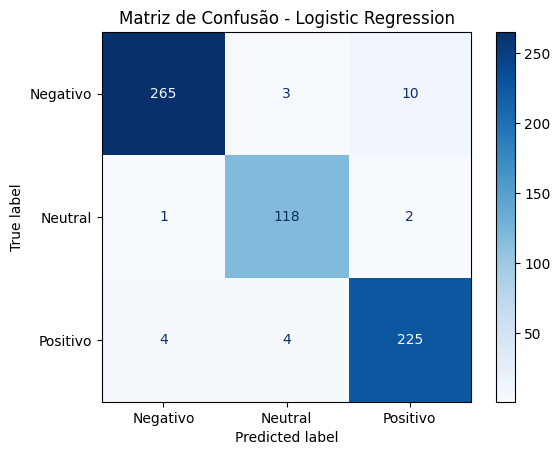

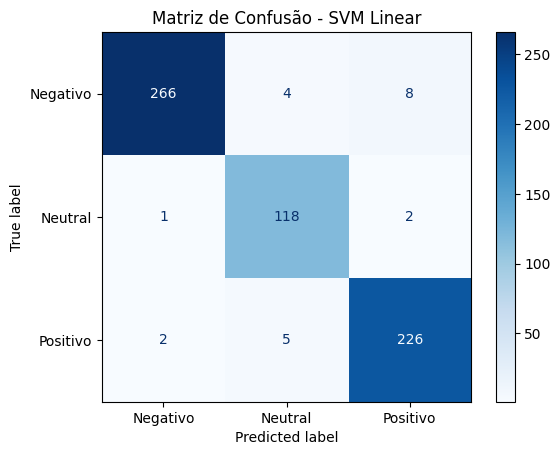

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# ===== Matriz de Confusão - Logistic Regression =====
cm_lr = confusion_matrix(
    y_test,
    y_pred_lr,
    labels=lr_model_es.classes_
)

disp_lr = ConfusionMatrixDisplay(
    confusion_matrix=cm_lr,
    display_labels=lr_model_es.classes_
)

disp_lr.plot(cmap='Blues')
plt.title('Matriz de Confusão - Logistic Regression')
plt.grid(False)
plt.show()


# ===== Matriz de Confusão - SVM Linear =====
cm_svm = confusion_matrix(
    y_test,
    y_pred_svm,
    labels=svm_model_es.classes_
)

disp_svm = ConfusionMatrixDisplay(
    confusion_matrix=cm_svm,
    display_labels=svm_model_es.classes_
)

disp_svm.plot(cmap='Blues')
plt.title('Matriz de Confusão - SVM Linear')
plt.grid(False)
plt.show()


# 16. Comparação gráfica: LR vs SVM

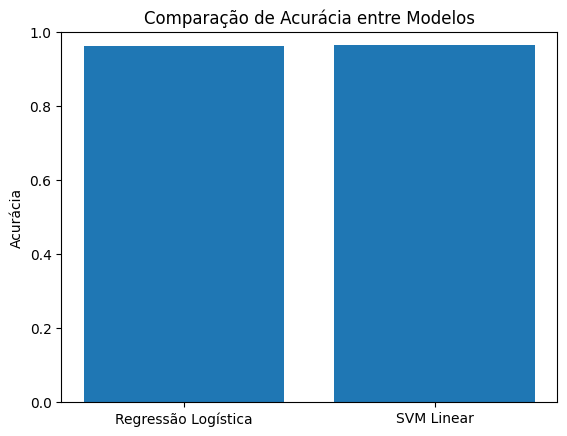

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# Predições (garantia contra erro de execução fora de ordem)
y_pred_lr = lr_model_es.predict(X_test_tfidf)
y_pred_svm = svm_model_es.predict(X_test_tfidf)

# Cálculo das acurácias
acc_lr = accuracy_score(y_test, y_pred_lr)
acc_svm = accuracy_score(y_test, y_pred_svm)

# Dados para o gráfico
models = ['Regressão Logística', 'SVM Linear']
accuracy_scores = [acc_lr, acc_svm]

# Gráfico de barras
plt.figure()
plt.bar(models, accuracy_scores)
plt.ylabel('Acurácia')
plt.title('Comparação de Acurácia entre Modelos')
plt.ylim(0, 1)  # padrão para métricas de classificação
plt.show()



# 17. Validação Cruzada Estratificada

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


lr_cv_scores = cross_val_score(
  lr_model_es,
  X_train_tfidf,
  y_train_bal,
  cv=skf,
  scoring='f1_macro'
)


svm_cv_scores = cross_val_score(
  svm_model_es,
  X_train_tfidf,
  y_train_bal,
  cv=skf,
  scoring='f1_macro'
)


print('LR - Média F1:', lr_cv_scores.mean())
print('SVM - Média F1:', svm_cv_scores.mean())

LR - Média F1: 0.9858911554732055
SVM - Média F1: 0.9915938589949572


# 18. Teste prático – frases novas

In [ ]:
frases_teste = [
  "Muy insatisfecho con el servicio. No resolvieron mi problema.",
  "No me gustó. El color es muy diferente al de la foto del anuncio.",
  "El producto es honesto, cumple lo que promete sin lujos.",
  "La entrega se retrasó demasiado y la caja llegó aplastada.",
  "Simplemente fantástico, ¡superó todas mis expectativas!",
  "Llegó roto, quiero que me devuelvan el dinero inmediatamente."
]


frases_proc = [preprocess_text(f) for f in frases_teste]
frases_vec = tfidf.transform(frases_proc)


predicoes = lr_model_es.predict(frases_vec)
probs = lr_model_es.predict_proba(frases_vec)


pd.DataFrame({
    'Texto': frases_teste,
    'Predição': predicoes,
    'Confiança': probs.max(axis=1)
})

,Texto,Predição,Confiança
0,Muy insatisfecho con el servicio. No resolvier...,Negativo,0.604657
1,No me gustó. El color es muy diferente al de l...,Negativo,0.498963
2,"El producto es honesto, cumple lo que promete ...",Neutral,0.878211
3,La entrega se retrasó demasiado y la caja lleg...,Negativo,0.873839
4,"Simplemente fantástico, ¡superó todas mis expe...",Positivo,0.760236
5,"Llegó roto, quiero que me devuelvan el dinero ...",Negativo,0.822715


# 19. Salvando modelos

In [ ]:
import os
import joblib

# Criar pasta 'models' se não existir
os.makedirs('models', exist_ok=True)

# Salvar os modelos e o vetor TF-IDF
joblib.dump(lr_model_es, 'models/modelo_lr_sentimentos_ES_V1.pkl')
joblib.dump(svm_model_es, 'models/modelo_svm_sentimentos_ES_V1.pkl')
joblib.dump(tfidf, 'models/tfidf_ES_V1.pkl')

print("Tudo pronto para testes com os modelos salvos ✅")

Tudo pronto para testes com os modelos salvos ✅


In [ ]:
from google.colab import drive
drive.mount('/content/drive')